设置matplotlib中文字体



In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font",family='SimHei') # 中文字体
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负


In [2]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")


获取计算硬件


In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)


device cuda:0


图像预处理


In [4]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])


载入图像分类数据集


In [5]:
# 数据集文件夹路径
dataset_dir = 'animals_split'


In [6]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)


训练集路径 animals_split\train
测试集路径 animals_split\val


In [7]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)


In [8]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)


训练集图像数量 4332
类别个数 89
各类别名称 ['乌鸦', '乌龟', '仓鼠', '企鹅', '兔子', '刺猬', '啄木鸟', '土狼', '大猩猩', '大象', '奶牛', '山羊', '斑马', '松鼠', '毛毛虫', '水母', '水獭', '河马', '浣熊', '海星', '海豚', '海豹', '海马', '火烈鸟', '火鸡', '熊', '熊猫', '牛', '牡蛎', '犀牛', '犀鸟', '狐狸', '狗', '狮子', '狼', '猩猩', '猪', '猫', '猫头鹰', '獾', '瓢虫', '甲虫', '章鱼', '羊', '羚羊', '老虎', '老鼠', '考拉', '苍蝇', '蚊子', '蚱蜢', '蛇', '蛾', '蜂鸟', '蜜蜂', '蜥蜴', '蜻蜓', '蝙蝠', '蝴蝶', '蟑螂', '蟹', '袋熊', '袋鼠', '豪猪', '豹', '负鼠', '野牛', '野猪', '金鱼', '霍加皮', '马', '驯鹿', '驴', '鬣狗', '鱿鱼', '鲨鱼', '鲸鱼', '鸭', '鸽子', '鹅', '鹈鹕', '鹦鹉', '鹬', '鹰', '鹿', '麻雀', '黑猩猩', '鼠', '龙虾']


类别和索引号 一一对应


In [9]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)


In [10]:
class_names


['乌鸦',
 '乌龟',
 '仓鼠',
 '企鹅',
 '兔子',
 '刺猬',
 '啄木鸟',
 '土狼',
 '大猩猩',
 '大象',
 '奶牛',
 '山羊',
 '斑马',
 '松鼠',
 '毛毛虫',
 '水母',
 '水獭',
 '河马',
 '浣熊',
 '海星',
 '海豚',
 '海豹',
 '海马',
 '火烈鸟',
 '火鸡',
 '熊',
 '熊猫',
 '牛',
 '牡蛎',
 '犀牛',
 '犀鸟',
 '狐狸',
 '狗',
 '狮子',
 '狼',
 '猩猩',
 '猪',
 '猫',
 '猫头鹰',
 '獾',
 '瓢虫',
 '甲虫',
 '章鱼',
 '羊',
 '羚羊',
 '老虎',
 '老鼠',
 '考拉',
 '苍蝇',
 '蚊子',
 '蚱蜢',
 '蛇',
 '蛾',
 '蜂鸟',
 '蜜蜂',
 '蜥蜴',
 '蜻蜓',
 '蝙蝠',
 '蝴蝶',
 '蟑螂',
 '蟹',
 '袋熊',
 '袋鼠',
 '豪猪',
 '豹',
 '负鼠',
 '野牛',
 '野猪',
 '金鱼',
 '霍加皮',
 '马',
 '驯鹿',
 '驴',
 '鬣狗',
 '鱿鱼',
 '鲨鱼',
 '鲸鱼',
 '鸭',
 '鸽子',
 '鹅',
 '鹈鹕',
 '鹦鹉',
 '鹬',
 '鹰',
 '鹿',
 '麻雀',
 '黑猩猩',
 '鼠',
 '龙虾']

In [11]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx


{'乌鸦': 0,
 '乌龟': 1,
 '仓鼠': 2,
 '企鹅': 3,
 '兔子': 4,
 '刺猬': 5,
 '啄木鸟': 6,
 '土狼': 7,
 '大猩猩': 8,
 '大象': 9,
 '奶牛': 10,
 '山羊': 11,
 '斑马': 12,
 '松鼠': 13,
 '毛毛虫': 14,
 '水母': 15,
 '水獭': 16,
 '河马': 17,
 '浣熊': 18,
 '海星': 19,
 '海豚': 20,
 '海豹': 21,
 '海马': 22,
 '火烈鸟': 23,
 '火鸡': 24,
 '熊': 25,
 '熊猫': 26,
 '牛': 27,
 '牡蛎': 28,
 '犀牛': 29,
 '犀鸟': 30,
 '狐狸': 31,
 '狗': 32,
 '狮子': 33,
 '狼': 34,
 '猩猩': 35,
 '猪': 36,
 '猫': 37,
 '猫头鹰': 38,
 '獾': 39,
 '瓢虫': 40,
 '甲虫': 41,
 '章鱼': 42,
 '羊': 43,
 '羚羊': 44,
 '老虎': 45,
 '老鼠': 46,
 '考拉': 47,
 '苍蝇': 48,
 '蚊子': 49,
 '蚱蜢': 50,
 '蛇': 51,
 '蛾': 52,
 '蜂鸟': 53,
 '蜜蜂': 54,
 '蜥蜴': 55,
 '蜻蜓': 56,
 '蝙蝠': 57,
 '蝴蝶': 58,
 '蟑螂': 59,
 '蟹': 60,
 '袋熊': 61,
 '袋鼠': 62,
 '豪猪': 63,
 '豹': 64,
 '负鼠': 65,
 '野牛': 66,
 '野猪': 67,
 '金鱼': 68,
 '霍加皮': 69,
 '马': 70,
 '驯鹿': 71,
 '驴': 72,
 '鬣狗': 73,
 '鱿鱼': 74,
 '鲨鱼': 75,
 '鲸鱼': 76,
 '鸭': 77,
 '鸽子': 78,
 '鹅': 79,
 '鹈鹕': 80,
 '鹦鹉': 81,
 '鹬': 82,
 '鹰': 83,
 '鹿': 84,
 '麻雀': 85,
 '黑猩猩': 86,
 '鼠': 87,
 '龙虾': 88}

In [12]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}


In [13]:
idx_to_labels

{0: '乌鸦',
 1: '乌龟',
 2: '仓鼠',
 3: '企鹅',
 4: '兔子',
 5: '刺猬',
 6: '啄木鸟',
 7: '土狼',
 8: '大猩猩',
 9: '大象',
 10: '奶牛',
 11: '山羊',
 12: '斑马',
 13: '松鼠',
 14: '毛毛虫',
 15: '水母',
 16: '水獭',
 17: '河马',
 18: '浣熊',
 19: '海星',
 20: '海豚',
 21: '海豹',
 22: '海马',
 23: '火烈鸟',
 24: '火鸡',
 25: '熊',
 26: '熊猫',
 27: '牛',
 28: '牡蛎',
 29: '犀牛',
 30: '犀鸟',
 31: '狐狸',
 32: '狗',
 33: '狮子',
 34: '狼',
 35: '猩猩',
 36: '猪',
 37: '猫',
 38: '猫头鹰',
 39: '獾',
 40: '瓢虫',
 41: '甲虫',
 42: '章鱼',
 43: '羊',
 44: '羚羊',
 45: '老虎',
 46: '老鼠',
 47: '考拉',
 48: '苍蝇',
 49: '蚊子',
 50: '蚱蜢',
 51: '蛇',
 52: '蛾',
 53: '蜂鸟',
 54: '蜜蜂',
 55: '蜥蜴',
 56: '蜻蜓',
 57: '蝙蝠',
 58: '蝴蝶',
 59: '蟑螂',
 60: '蟹',
 61: '袋熊',
 62: '袋鼠',
 63: '豪猪',
 64: '豹',
 65: '负鼠',
 66: '野牛',
 67: '野猪',
 68: '金鱼',
 69: '霍加皮',
 70: '马',
 71: '驯鹿',
 72: '驴',
 73: '鬣狗',
 74: '鱿鱼',
 75: '鲨鱼',
 76: '鲸鱼',
 77: '鸭',
 78: '鸽子',
 79: '鹅',
 80: '鹈鹕',
 81: '鹦鹉',
 82: '鹬',
 83: '鹰',
 84: '鹿',
 85: '麻雀',
 86: '黑猩猩',
 87: '鼠',
 88: '龙虾'}

In [14]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)


定义数据加载器DataLoader


In [15]:
from torch.utils.data import DataLoader


In [16]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )


查看一个batch的图像和标注


In [17]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))


In [18]:
images.shape


torch.Size([32, 3, 224, 224])

In [19]:
labels


tensor([82, 38,  7, 80, 19, 37, 10, 10,  3, 49, 52,  1, 74, 61, 73, 55, 85, 73,
        43, 87, 87, 78, 68, 41, 30, 29, 46, 66, 81, 14, 50, 33])

可视化一个batch的图像和标注



In [20]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()


In [21]:
images[5].shape


(3, 224, 224)

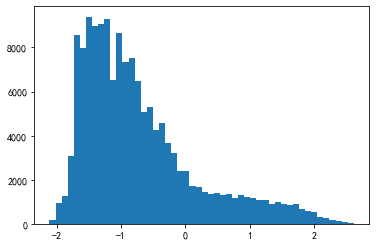

In [22]:
plt.hist(images[5].flatten(), bins=50)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:7')

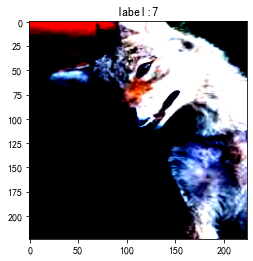

In [23]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))


In [24]:
label = labels[idx].item()


In [25]:
label


7

In [26]:
pred_classname = idx_to_labels[label]


In [27]:
pred_classname


'土狼'

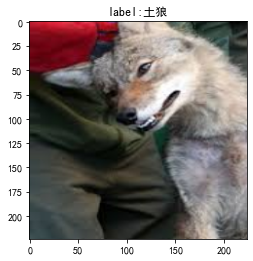

In [28]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()


导入训练需使用的工具包


In [29]:
from torchvision import models
import torch.optim as optim


只微调训练模型最后一层（全连接分类层）


In [30]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)


In [31]:
model.fc


Linear(in_features=512, out_features=89, bias=True)

In [32]:
# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())


训练配置


In [33]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 训练轮次 Epoch
EPOCHS = 20


模拟一个batch的训练


In [34]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)


In [35]:
# 输入模型，执行前向预测
outputs = model(images)


In [36]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape


torch.Size([32, 89])

In [37]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)


In [38]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新


In [39]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)


In [40]:
preds


tensor([82, 12, 83,  5, 83, 60, 81, 61, 83, 74, 11,  8, 84, 83, 83, 84, 61, 61,
        83, 88, 32, 61, 38,  5, 54, 35, 15, 67, 83,  5, 51, 83],
       device='cuda:0')

In [41]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获得一个 batch 的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


100%|██████████| 20/20 [10:13<00:00, 30.69s/it]


In [42]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]

测试集上的准确率为 88.015 %


In [44]:
torch.save(model, 'checkpoints/animals20230106.pth')
